<a href="https://colab.research.google.com/github/034-BikashKumarYadav/Research-Intern-NITT/blob/main/AI_Driven_Colorectal_Cancer_Detection_Using_ML_%26_DL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


## Load The Dataset

In [ ]:
tfds.disable_progress_bar()

# Reserve 10% for validation and 10% for test
(train_ds, validation_ds, test_ds), info = tfds.load("colorectal_histology",
                                                     split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
                                                     as_supervised=True,
                                                     with_info=True)

print("Number of training examples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation examples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test examples: %d" % tf.data.experimental.cardinality(test_ds))

num_classes = info.features['label'].num_classes
print("Number of classes: %d" % num_classes)

original_image_size = info.features['image'].shape
print(f"Original image size: {original_image_size}")

# Get class names
class_names = info.features["label"].names
print(f"class names are: {class_names}")

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
Number of training examples: 4000
Number of validation examples: 500
Number of test examples: 500
Number of classes: 8
Original image size: (150, 150, 3)
class names are: ['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']


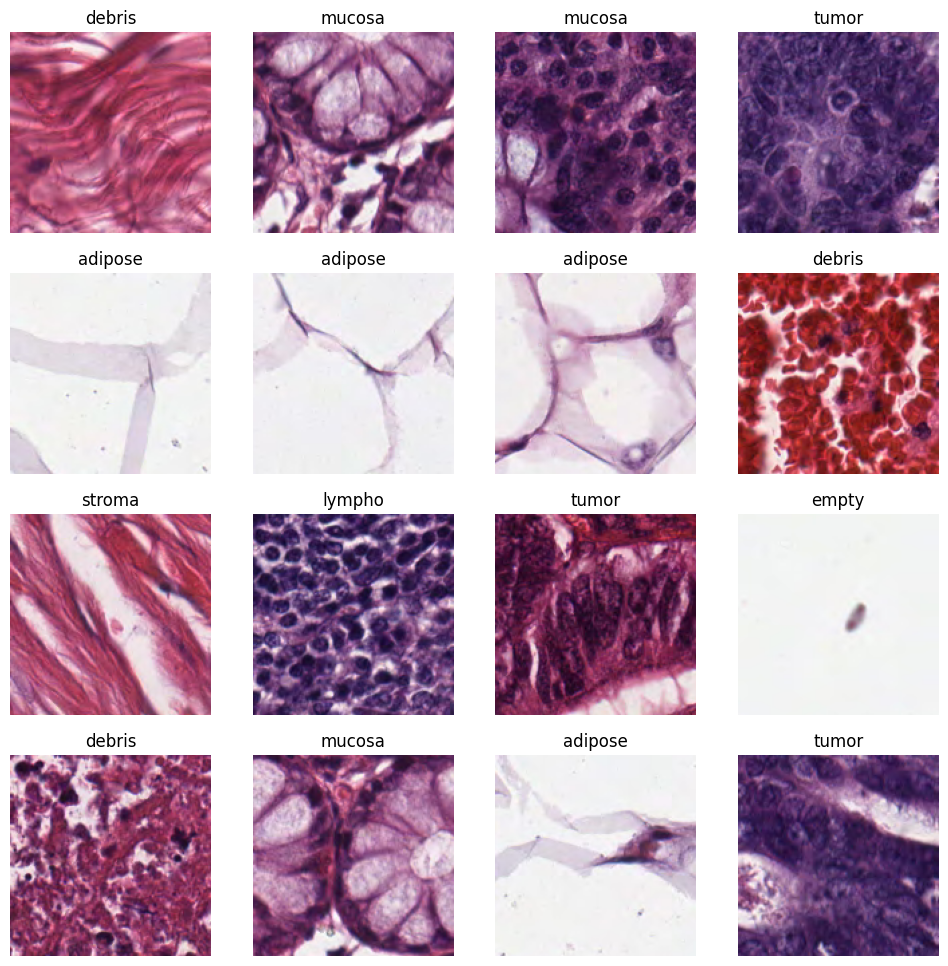

In [ ]:
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(train_ds.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(class_names[int(label)])
    plt.axis("off")

## Standardizing The Data

In [ ]:
# Resizing the images
img_size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))

In [ ]:
# Batch, cache, and prefetch the data
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=5)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=5)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=5)

##Data Augmentation

In [ ]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name ="data_augmentation")

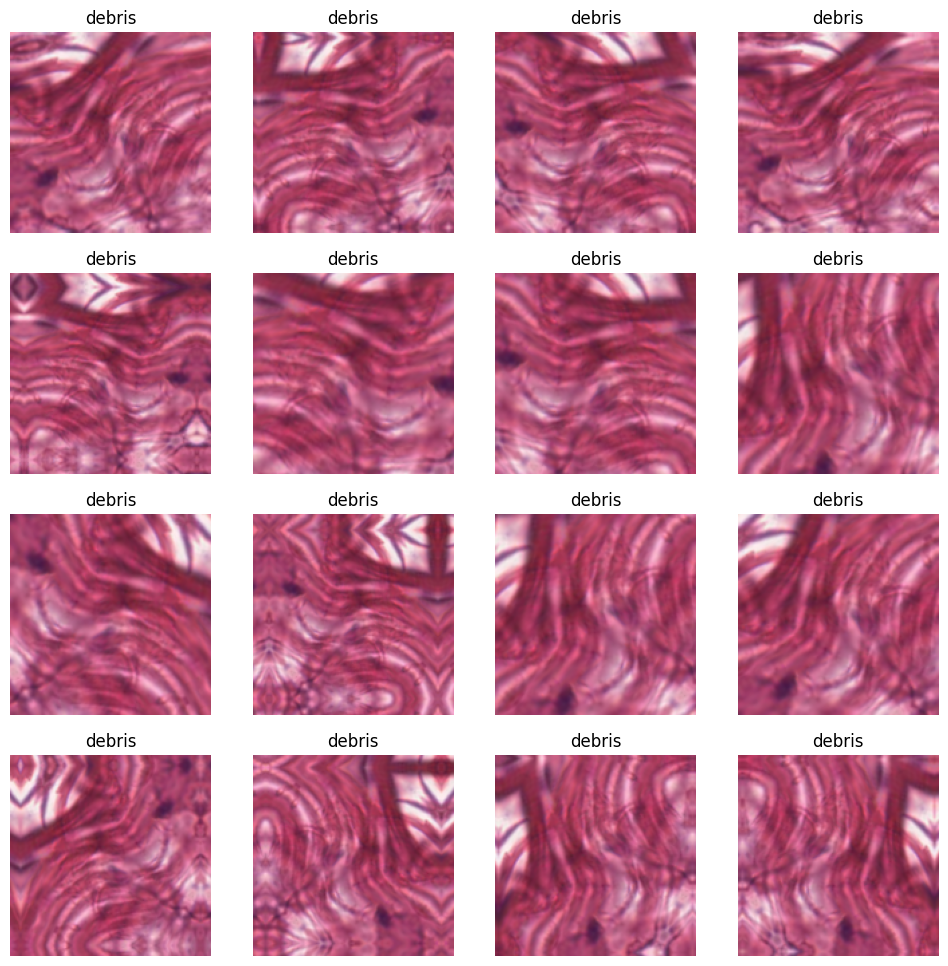

In [ ]:
# Visualizing the 1st image of the 1st batch after 16 random augmentation
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    image = images[0]
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        aug_img = data_augmentation(tf.expand_dims(image, 0), training=True)
        plt.imshow(tf.squeeze(aug_img).numpy().astype("int32"))
        plt.title(class_names[int(labels[0])])
        plt.axis("off")

# Build a model

Using ResNet50V2 model, pretrained on the ImageNet dataset, as base model.

Reference: [Identity Mappings in Deep Residual Networks] (https://arxiv.org/abs/1603.05027) (CVPR 2016)

## Feature extraction

In [ ]:
# Setup input shape and base model
input_shape = img_size + (3, )
base_model = keras.applications.ResNet50V2(weights="imagenet",
                                           input_shape=input_shape,
                                           include_top=False)
# Freeze the base_model
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=input_shape, name="input_layer")

# Apply random data augmentation
x = data_augmentation(inputs)

# Scaling input to a range of (-1., +1.) from (0, 255)
x = keras.layers.Rescaling(scale=1/127.5, offset=-1)(x)

# Running the base_model in inference mode so that batchnorm statistics don't get updated even for fine-tuning.
x = base_model(x, training=False)

# Convert outputs of the base model to vectors
x = keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output activation layer
outputs = keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 150, 150, 3)       0         
 ial)                                                            
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling_lay  (None, 2048)              0         
 er (GlobalAveragePooling2D                                      
 )                                                            

In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_feature_extraction = model.fit(train_ds,
                                       epochs=20,
                                       validation_data=validation_ds)

Epoch 1/20
125/125 [==============================] - 19s 92ms/step - loss: 0.7932 - accuracy: 0.7335 - val_loss: 0.4640 - val_accuracy: 0.8400
Epoch 2/20
125/125 [==============================] - 8s 62ms/step - loss: 0.4478 - accuracy: 0.8422 - val_loss: 0.3884 - val_accuracy: 0.8760
Epoch 3/20
125/125 [==============================] - 7s 59ms/step - loss: 0.3833 - accuracy: 0.8670 - val_loss: 0.3554 - val_accuracy: 0.8840
Epoch 4/20
125/125 [==============================] - 7s 60ms/step - loss: 0.3576 - accuracy: 0.8790 - val_loss: 0.3386 - val_accuracy: 0.8960
Epoch 5/20
125/125 [==============================] - 8s 60ms/step - loss: 0.3330 - accuracy: 0.8852 - val_loss: 0.3376 - val_accuracy: 0.8960
Epoch 6/20
125/125 [==============================] - 7s 58ms/step - loss: 0.3140 - accuracy: 0.8888 - val_loss: 0.3146 - val_accuracy: 0.9040
Epoch 7/20
125/125 [==============================] - 7s 59ms/step - loss: 0.2984 - accuracy: 0.8953 - val_loss: 0.3196 - val_accuracy: 0.904

## Setup callbacks

In [ ]:
# Create learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

## Fine-tuning

In [ ]:
# Unfreeze the entire base model
base_model.trainable = True

# Freeze all layers except the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 150, 150, 3)       0         
 ial)                                                            
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling_lay  (None, 2048)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                             

In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["accuracy"])

# Fit the model
history_fine_tuning = model.fit(train_ds,
                                epochs=20,
                                validation_data=validation_ds,
                                callbacks=[reduce_lr])

Epoch 1/20
125/125 [==============================] - 14s 71ms/step - loss: 0.2194 - accuracy: 0.9233 - val_loss: 0.2637 - val_accuracy: 0.9200 - lr: 1.0000e-05
Epoch 2/20
125/125 [==============================] - 8s 64ms/step - loss: 0.2075 - accuracy: 0.9273 - val_loss: 0.2662 - val_accuracy: 0.9120 - lr: 1.0000e-05
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9265
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
125/125 [==============================] - 8s 64ms/step - loss: 0.2063 - accuracy: 0.9265 - val_loss: 0.2637 - val_accuracy: 0.9140 - lr: 1.0000e-05
Epoch 4/20
125/125 [==============================] - 8s 65ms/step - loss: 0.1974 - accuracy: 0.9333 - val_loss: 0.2565 - val_accuracy: 0.9140 - lr: 2.0000e-06
Epoch 5/20
125/125 [==============================] - 8s 66ms/step - loss: 0.1880 - accuracy: 0.9327 - val_loss: 0.2586 - val_accuracy: 0.9200 - lr: 2.0000e-06
Epoch 6/20
125/125 [=================

# Evaluation

## Loss curves

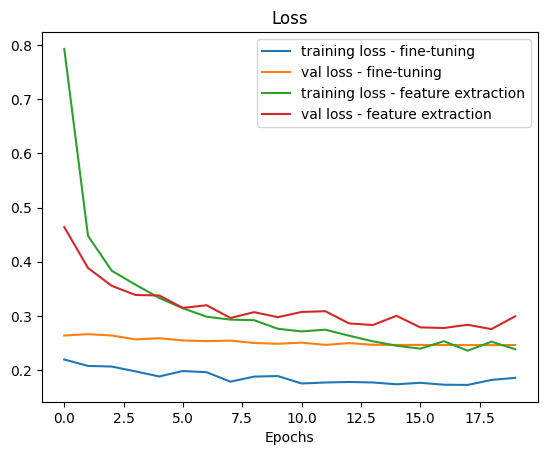

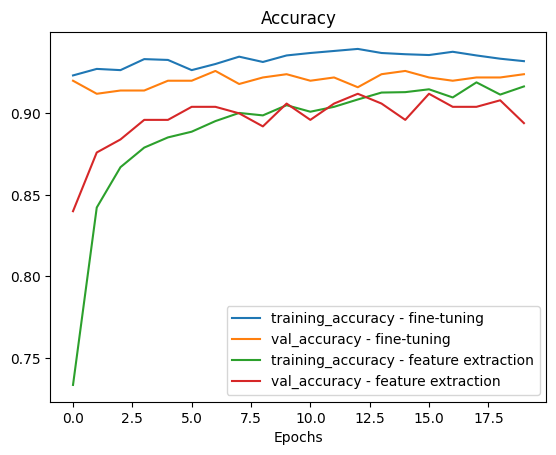

In [ ]:
# Comparing accuracy and loss curves for training and validation sets for feature extraction and fine-tuning
loss_fn = history_fine_tuning.history['loss']
val_loss_fn = history_fine_tuning.history['val_loss']
accuracy_fn = history_fine_tuning.history['accuracy']
val_accuracy_fn = history_fine_tuning.history['val_accuracy']

loss_fe = history_feature_extraction.history['loss']
val_loss_fe = history_feature_extraction.history['val_loss']
accuracy_fe = history_feature_extraction.history['accuracy']
val_accuracy_fe = history_feature_extraction.history['val_accuracy']

epochs = range(len(history_fine_tuning.history['loss']))

# Plot loss
plt.figure()
plt.plot(epochs, loss_fn, label='training loss - fine-tuning')
plt.plot(epochs, val_loss_fn, label='val loss - fine-tuning')
plt.plot(epochs, loss_fe, label='training loss - feature extraction')
plt.plot(epochs, val_loss_fe, label='val loss - feature extraction')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend();

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy_fn, label='training_accuracy - fine-tuning')
plt.plot(epochs, val_accuracy_fn, label='val_accuracy - fine-tuning')
plt.plot(epochs, accuracy_fe, label='training_accuracy - feature extraction')
plt.plot(epochs, val_accuracy_fe, label='val_accuracy - feature extraction')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

## Evaluate on test data

In [ ]:
# Evaluate the model on the test data
print("Evaluation on Test data \n")
loss, accuracy = model.evaluate(test_ds, batch_size=32)
print(f"\nModel loss on test set: {(loss):.2f}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

Evaluation on Test data 

16/16 [==============================] - 1s 50ms/step - loss: 0.2493 - accuracy: 0.9120

Model loss on test set: 0.25
Model accuracy on test set: 91.20%


## Confusion matrix & classification report

In [ ]:
# Model prediction for test data
pred = model.predict(test_ds)

# Match the prediction class to the highest prediction probability
y_pred = [pred[i].argmax() for i in range(len(pred))]
y_pred_class = [class_names[y_pred[i]] for i in range(len(y_pred))]

# Extract the truth ground label and match to class_names
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_class = [class_names[y_true[i]] for i in range(len(y_true))]

16/16 [==============================] - 2s 49ms/step


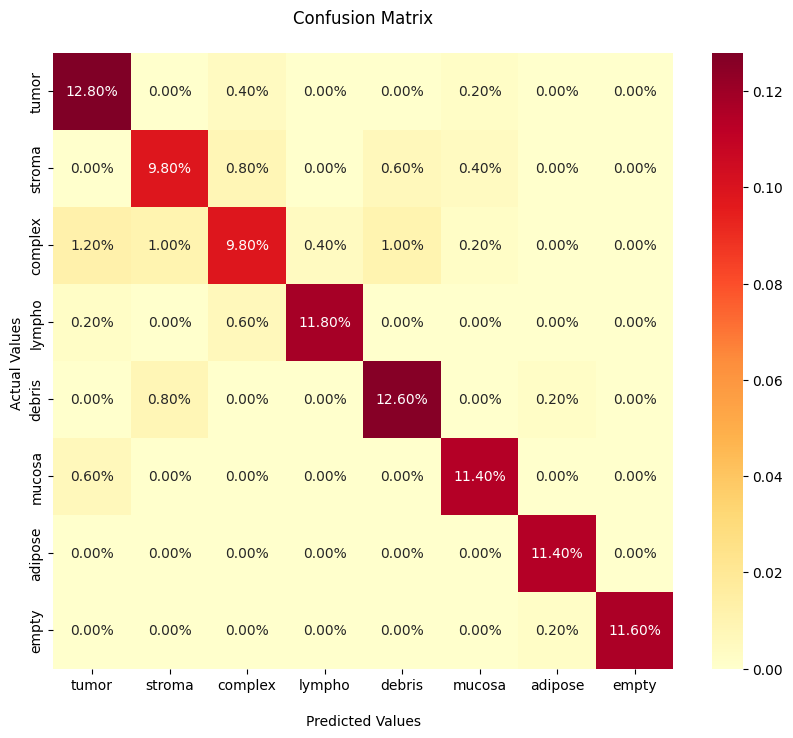

In [ ]:
# Plot confusion matrix from predictions
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='YlOrRd')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.show()

In [ ]:
# Classification report
print(classification_report(y_true_class, y_pred_class, digits=3))

              precision    recall  f1-score   support

     adipose      0.966     1.000     0.983        57
     complex      0.845     0.721     0.778        68
      debris      0.887     0.926     0.906        68
       empty      1.000     0.983     0.991        59
      lympho      0.967     0.937     0.952        63
      mucosa      0.934     0.950     0.942        60
      stroma      0.845     0.845     0.845        58
       tumor      0.865     0.955     0.908        67

    accuracy                          0.912       500
   macro avg      0.914     0.915     0.913       500
weighted avg      0.912     0.912     0.911       500



## Visualization of f1-score

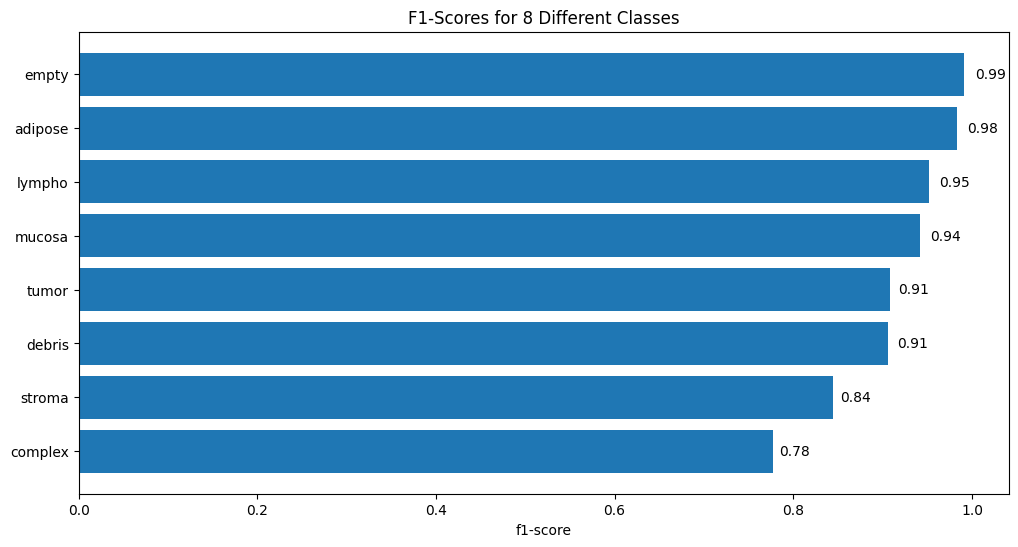

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true_class, y_pred_class, output_dict=True)

# Extracting f1 scores from classification report dictionary
class_f1_scores = {}

# Loop through classification report items
for key, value in classification_report_dict.items():
  # stop once we get to accuracy key
  if key == "accuracy":
    break
  else:
    # Append keys and f1-scores to new dictionary
    class_f1_scores[key] = value["f1-score"]

# Turn f1-scores into dataframe for visualization
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

# Visualization with a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 6))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 8 Different Classes")
ax.invert_yaxis(); # reverse the order

# Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
def autolabel(scores):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for score in scores:
    width = score.get_width()
    ax.text(1.03*width, score.get_y() + score.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

# Summary

By training the top 10 layers of the base model, ResNet50V2, an accuracy of  90% is achieved on validation and test sets.